In [1]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\behlul\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, resample

In [3]:
train=pd.read_csv("train.tsv.zip", sep="	")
test=pd.read_csv("test.tsv.zip", sep="	")
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [5]:
train.dtypes

PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object

In [6]:
labels=train.Sentiment

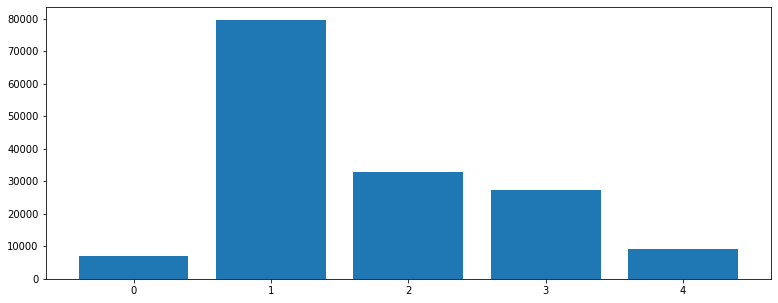

In [7]:
plt.figure(figsize=(13,5))
plt.bar(height=train.Sentiment.value_counts(), x=train.Sentiment.unique())
plt.show()

In [8]:
#Kolay metin temizleme ve işleme için İfadeyi bir listeye alın
raw_phrases = train.Phrase.values
raw_phrases[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [9]:
#Normal ifadeler kullanarak IP adreslerini ve URL'leri kaldırın
phrases_ip_remove = [re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text) for text in raw_phrases]
phrases_ip_remove[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [10]:
#Normal ifadeler kullanarak özel karakterleri kaldırın
phrases_spl_remove = [re.sub('[^A-Za-z \']+', '', text) for text in phrases_ip_remove]
phrases_spl_remove[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story '

In [11]:
#case normalize
phrases_lower=[text.lower() for text in phrases_spl_remove]
phrases_lower[0]

'a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story '

In [12]:
phrases_word_tok0=[word_tokenize(text) for text in phrases_lower]
phrases_word_tok0[0]

['a',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story']

In [13]:
phrases_word_tok=[]
for words in phrases_word_tok0:
    phrases_word_tok.append([word for word in words if word not in punctuation])
phrases_word_tok[0]

['a',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story']

In [14]:
cleaned_phrases_train=[]
for text in phrases_word_tok:
    cleaned_phrases_train.append(" ".join(word for word in text))
cleaned_phrases_train[0]

'a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story'

In [15]:
x_train, x_val, y_train, y_val = train_test_split(cleaned_phrases_train, labels, test_size=0.10, random_state=10)

In [16]:
labels=train.Sentiment.values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
x_train=pad_sequences(sequences, maxlen=200)
sequences = tokenizer.texts_to_sequences(x_val)
x_val=pad_sequences(sequences, maxlen=200)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((140454, 200), (140454,), (15606, 200), (15606,))

In [17]:
#Test verileri için Ön İşleme İşlevi
def Preprocess(test):
        
    #Kolay metin temizleme ve işleme için İfadeyi bir listeye alın
    raw_phrases = test.Phrase.values
    
    #Normal ifadeler kullanarak URL'leri kaldırın
    phrases_ip_remove = [re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text) for text in raw_phrases]
    
       
    #Normal ifadeler kullanarak özel karakterleri kaldırın
    phrases_spl_remove = [re.sub('[^A-Za-z \']+', '', text) for text in phrases_ip_remove]
    phrases_spl_remove[0]

    #case normalize 
    phrases_lower=[text.lower() for text in phrases_spl_remove]
    
    phrases_word_tok0=[word_tokenize(text) for text in phrases_lower]
    
    phrases_word_tok=[]
    for words in phrases_word_tok0:
        phrases_word_tok.append([word for word in words if word not in punctuation])
    phrases_word_tok[0]
    
    cleaned_phrases=[]
    for text in phrases_word_tok:
        cleaned_phrases.append(" ".join(word for word in text))

    sequences = tokenizer.texts_to_sequences(cleaned_phrases)
    test_trans=pad_sequences(sequences, maxlen=200)

    return test_trans

In [18]:
model=Sequential()
model.add(Embedding(20000, 500, input_length=x_train.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 500)          10000000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              289280    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model.fit(x_train, to_categorical(y_train), epochs=5, batch_size=289, validation_data=(x_val, to_categorical(y_val)))

Epoch 1/12
486/486 [==============================] - 866s 2s/step - loss: 1.2960 - accuracy: 0.5048 - val_loss: 1.0334 - val_accuracy: 0.6073
Epoch 2/12
486/486 [==============================] - 997s 2s/step - loss: 0.9156 - accuracy: 0.6337 - val_loss: 0.8731 - val_accuracy: 0.6439
Epoch 3/12
486/486 [==============================] - 1042s 2s/step - loss: 0.8126 - accuracy: 0.6703 - val_loss: 0.8268 - val_accuracy: 0.6594
Epoch 4/12
486/486 [==============================] - 1031s 2s/step - loss: 0.7543 - accuracy: 0.6913 - val_loss: 1.2016 - val_accuracy: 0.5197
Epoch 5/12
486/486 [==============================] - 1033s 2s/step - loss: 0.7030 - accuracy: 0.7129 - val_loss: 0.8416 - val_accuracy: 0.6563
Epoch 6/12
486/486 [==============================] - 1039s 2s/step - loss: 0.6666 - accuracy: 0.7255 - val_loss: 0.8579 - val_accuracy: 0.6673
Epoch 7/12
486/486 [==============================] - 1067s 2s/step - loss: 0.6391 - accuracy: 0.7371 - val_loss: 1.4348 - val_accuracy: 0

KeyboardInterrupt: 

NameError: name 'history' is not defined

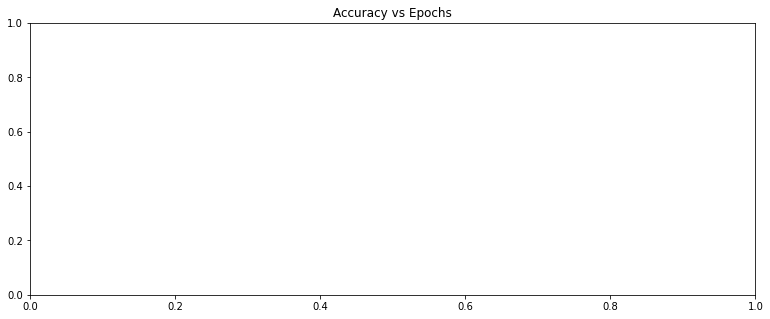

In [21]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [22]:
model.evaluate(x_val, to_categorical(y_val))

488/488 [==============================] - 116s 236ms/step - loss: 1.5869 - accuracy: 0.5061


[1.5868918895721436, 0.5060874223709106]

In [23]:
test_data = Preprocess(test)
test['Sentiment'] = np.argmax(model.predict(test_data), axis=1)

2072/2072 [==============================] - 338s 163ms/step


In [24]:
test.loc[:,['PhraseId','Sentiment']].to_csv("./Submission2.csv", index=False)